In [62]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_item, show_grasp
from dataset import ToyGraspDataset
import torch

%load_ext autoreload
%autoreload 2


np.random.seed(10)
torch.manual_seed(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Outline
1. Make datasets
2. Train Network
3. Save results

In [63]:
item = load_item('fork')

In [81]:
dataset = ToyGraspDataset(root='data', size=1200)

In [65]:
pos_ind = np.argwhere(dataset.data[:,2] == 1)
neg_ind = np.argwhere(dataset.data[:,2] == 0)

pos_ind = np.random.choice(pos_ind.squeeze(), 5)
neg_ind = np.random.choice(neg_ind.squeeze(), 5)

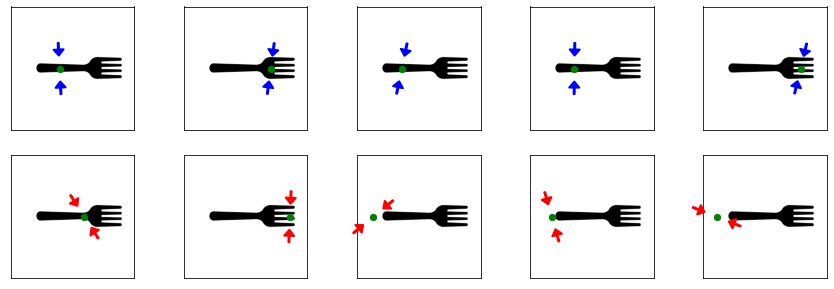

In [66]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15,5))

for i in range(5):
    ax[0][i].imshow(item, cmap='Greys')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    sample = dataset.data[pos_ind[i]]
    show_grasp(ax[0][i], sample[0], sample[1], sample[2] )
    ax[1][i].imshow(item, cmap='Greys')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    sample = dataset.data[neg_ind[i]]
    show_grasp(ax[1][i], sample[0], sample[1], sample[2] )

In [67]:
# show the data
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks
handle_masks = data[:,3] == 1
pos_combined_masks = handle_masks & pos_masks
neg_combined_masks = handle_masks & neg_masks

In [68]:
np.unique(data[:,1])

array([1.8879855e-03, 1.5770227e-02, 1.6886223e-02, ..., 6.2768455e+00,
       6.2809854e+00, 6.2831211e+00], dtype=float32)

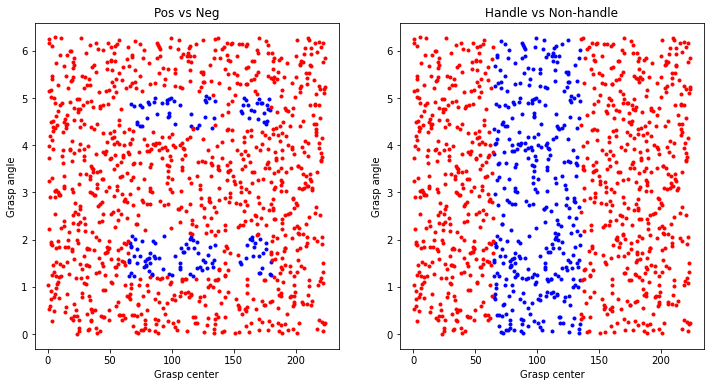

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax[0].scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax[0].set_title('Pos vs Neg')
ax[0].set_xlabel('Grasp center')
ax[0].set_ylabel('Grasp angle')

ax[1].scatter(data[handle_masks][:,0], data[handle_masks][:,1], marker='.', alpha=1.0, color='b')
ax[1].scatter(data[~handle_masks][:,0], data[~handle_masks][:,1], marker='.', alpha=1.0, color='r')
ax[1].set_title('Handle vs Non-handle')
ax[1].set_xlabel('Grasp center')
ax[1].set_ylabel('Grasp angle')
plt.show()

### Pos_vs_Neg

In [70]:
from torch.utils.data import TensorDataset, DataLoader
from network import ClassifierNN, train_network, save_model_info, load_model_info
import torch.optim as optim

torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [71]:
# train classifier
train_dataset = ToyGraspDataset(root='data', name='train_data', size=10000, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='test_data', size=1000, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [72]:
np.sum(train_dataset.data[:,2])/train_dataset.data.shape[0]

0.1023

In [73]:
# first classifier balanced
f = ClassifierNN([2,64,64,1])
f = f.to(device)
optimizer = optim.Adam(f.parameters(), lr=0.001)

In [74]:
f, info = train_network(f, train_dataloader, train_dataset,
                                      test_dataloader, test_dataset,
                                      n_epochs=1000, print_freq=40, optimizer=optimizer)
info['pos_samples_size'] = np.sum(train_dataset.data[:,2])
info['neg_samples_size'] = train_dataset.data.shape[0] - np.sum(train_dataset.data[:,2])
save_model_info(f, info, name='pos_vs_neg')

Epoch: 40
Train loss: 0.0009938661992549896 | Test losses: 0.0009706749618053436
Train acc: 0.8293 | Test acc: 0.793
Epoch: 80
Train loss: 0.0005416921094059944 | Test losses: 0.0005877958834171295
Train acc: 0.9207 | Test acc: 0.897
Epoch: 120
Train loss: 0.0004246585518121719 | Test losses: 0.00044360190629959105
Train acc: 0.9353 | Test acc: 0.926
Epoch: 160
Train loss: 0.0003501180052757263 | Test losses: 0.0003715972900390625
Train acc: 0.9459 | Test acc: 0.928
Epoch: 200
Train loss: 0.0003078563541173935 | Test losses: 0.00033960933983325956
Train acc: 0.9513 | Test acc: 0.931
Epoch: 240
Train loss: 0.000262895879149437 | Test losses: 0.0002838776856660843
Train acc: 0.9552 | Test acc: 0.938
Epoch: 280
Train loss: 0.0002472719445824623 | Test losses: 0.00024604493379592893
Train acc: 0.9579 | Test acc: 0.958
Epoch: 320
Train loss: 0.00021937103271484374 | Test losses: 0.00023448527604341506
Train acc: 0.9621 | Test acc: 0.957
Epoch: 360
Train loss: 0.00019216268211603163 | Test l

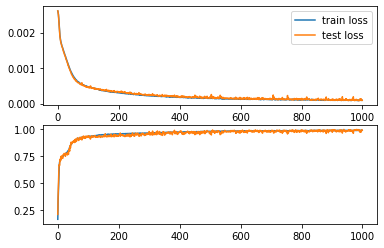

In [75]:
fig, ax = plt.subplots(2)
ax[0].plot(info['train_loss'], label='train loss')
ax[0].plot(info['test_loss'], label='test loss')

ax[0].legend()
ax[1].plot(info['train_acc'], label='Train')
ax[1].plot(info['test_acc'], label='Test')
plt.show()

Handle_vs_nonhandle

In [76]:
# train classifier
train_dataset = ToyGraspDataset(root='data', name='train_data', size=10000, is_pos_label=False, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='test_data', size=1000, is_pos_label=False, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [77]:
# first classifier balanced
f = ClassifierNN([2, 32, 1])
f = f.to(device)
optimizer = optim.Adam(f.parameters(), lr=0.001)

In [78]:
f, info = train_network(f, train_dataloader, train_dataset,
                                      test_dataloader, test_dataset,
                                      n_epochs=500, print_freq=40, optimizer=optimizer)
info['pos_samples_size'] = np.sum(train_dataset.data[:,2])
info['neg_samples_size'] = train_dataset.data.shape[0] - np.sum(train_dataset.data[:,2])
save_model_info(f, info, name='handle')

Epoch: 40
Train loss: 0.0013353539168834687 | Test losses: 0.0013236923217773437
Train acc: 0.9094 | Test acc: 0.914
Epoch: 80
Train loss: 0.0006812191173434257 | Test losses: 0.0006872738301753997
Train acc: 0.9555 | Test acc: 0.957
Epoch: 120
Train loss: 0.0004705933555960655 | Test losses: 0.0004733956903219223
Train acc: 0.9678 | Test acc: 0.967
Epoch: 160
Train loss: 0.0003577003635466099 | Test losses: 0.00036525511741638183
Train acc: 0.9725 | Test acc: 0.979
Epoch: 200
Train loss: 0.000291656194254756 | Test losses: 0.00029666323959827423
Train acc: 0.9785 | Test acc: 0.98
Epoch: 240
Train loss: 0.00024454786032438277 | Test losses: 0.0002515425868332386
Train acc: 0.9814 | Test acc: 0.981
Epoch: 280
Train loss: 0.0002175939790904522 | Test losses: 0.00022139113396406175
Train acc: 0.9842 | Test acc: 0.982
Epoch: 320
Train loss: 0.00019608578607439994 | Test losses: 0.00019979582354426385
Train acc: 0.9885 | Test acc: 0.988
Epoch: 360
Train loss: 0.00017461084559181473 | Test l

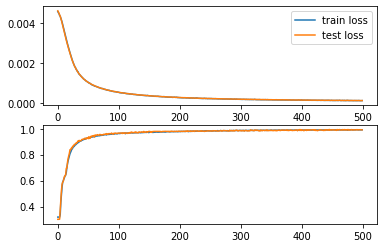

In [79]:
fig, ax = plt.subplots(2)
ax[0].plot(info['train_loss'], label='train loss')
ax[0].plot(info['test_loss'], label='test loss')

ax[0].legend()
ax[1].plot(info['train_acc'], label='Train')
ax[1].plot(info['test_acc'], label='Test')
plt.show()